This notebook is part of the supplementary material of the books "Online Machine Learning - Eine praxisorientiere Einführung",  
https://link.springer.com/book/9783658425043 and "Online Machine Learning - A Practical Guide with Examples in Python" https://link.springer.com/book/9789819970063
The contents are open source and published under the "BSD 3-Clause License".
This software is provided "as is" without warranty of any kind, either express or implied, including but not limited to implied warranties of merchantability and fitness for a particular purpose. The author or authors assume no liability for any damages or liability, whether in contract, tort, or otherwise, arising out of or in connection with the software or the use or other dealings with the software.

# Chapter 3: Drift Detection and Handling

In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from river import drift as riverdrift

# Concept Drift


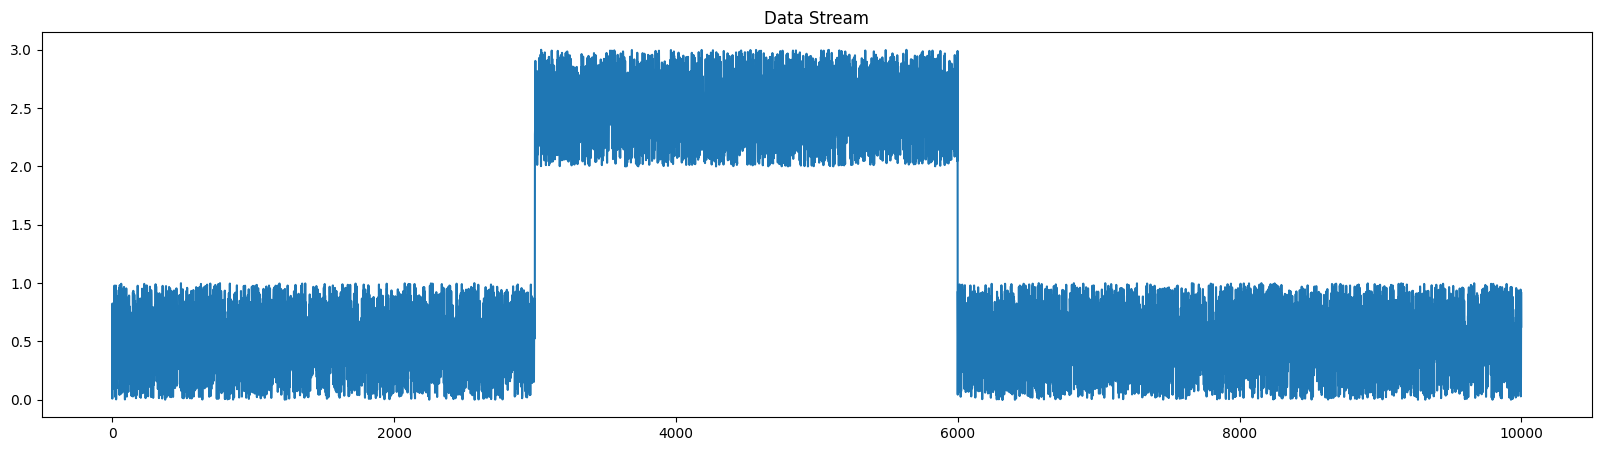

In [2]:
import random

rng = random.Random(12345)

data_stream = []
for i in range(10000):
    if i < 3000:
        data_stream.append(rng.uniform(0, 1))
    elif i < 6000:
        data_stream.append(rng.uniform(2, 3))
    else:
        data_stream.append(rng.uniform(0, 1))
## plot the data stream using points
plt.figure(figsize=(20, 5))
plt.plot(data_stream, '-')
plt.title("Data Stream")
plt.show()




* Auxiliary function `plot_data_drift` for visualizing drift detection:

In [3]:
def plot_data_drift(y, drifts=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    ax1 = plt.subplot(111)
    ax1.grid()
    ax1.plot(y, label='Stream', marker='o', linewidth=.001, markersize=0.1)    
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')
    plt.show()

## ADWIN: Adaptive Windowing Method for Concept Drift Detection.

* ADWIN (ADAptive WINDowing) is a popular drift detection method.
* The ADWIN drift detector indicates after each sample whether there is any drift in the data.
* ADWIN maintains a window $W$ with variable length of the last elements.
* This window is further divided into two subwindows, $(W_0, W_1)$, to determine if a change has occurred. To do this, ADWIN compares the mean of the data in $W_0$ and in $W_1$.
* Concept drift is detected when the mean values are no longer equal.
* If drift was detected, then $W_0$ is replaced by $W_1$ and $W_1$ is reinitialized.
* ADWIN uses a significance value $\delta \in (0,1)$ to determine if the two subwindows follow the same distribution.

Change detected at index 3103
Change detected at index 6143


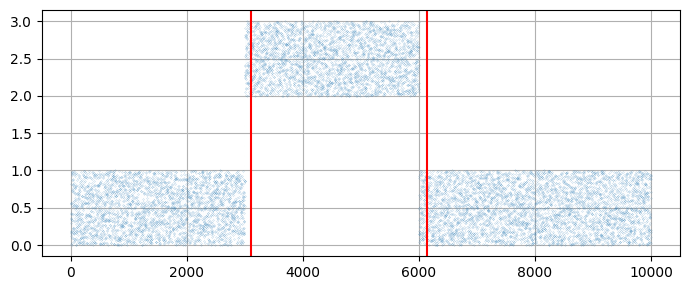

In [4]:
drift_detector = riverdrift.ADWIN(delta=1e-15)
drifts = []

for i, val in enumerate(data_stream):
    drift_detector.update(val)   
    if drift_detector.drift_detected:        
        print(f'Change detected at index {i}')
        drifts.append(i)
plot_data_drift(y=data_stream, drifts=drifts)

## Influence of the significance value

* The drift detection strongly depends on the significance value $\delta$, as the following example shows:

Change detected at index 3071
Change detected at index 6047


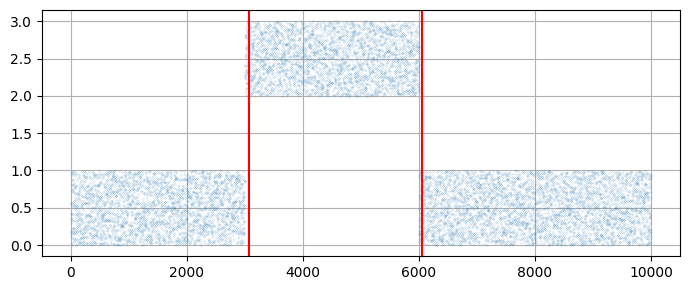

In [5]:
drift_detector = riverdrift.ADWIN(delta=1e-4, grace_period = 10)
drifts = []

for i, val in enumerate(data_stream):
    drift_detector.update(val)   
    if drift_detector.drift_detected:        
        print(f'Change detected at index {i}')
        drifts.append(i)
plot_data_drift(y=data_stream, drifts=drifts)

## Synthetic Drift with Three Distributions

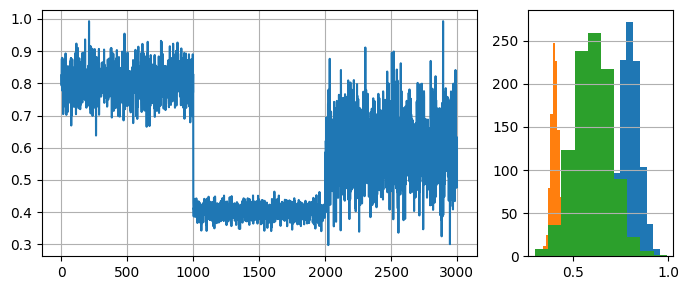

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
# Generate data for 3 distributions
random_state = np.random.RandomState(seed=42)
dist_a = random_state.normal(0.8, 0.05, 1000)
dist_b = random_state.normal(0.4, 0.02, 1000)
dist_c = random_state.normal(0.6, 0.1, 1000)

# Concatenate data to stream
stream = np.concatenate((dist_a, dist_b, dist_c))
def plot_data(stream, dist_a, dist_b, dist_c, drifts=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(stream, label='Stream')
    ax2.grid(axis='y')
    ax2.hist(dist_a, label=r'$dist_a$')
    ax2.hist(dist_b, label=r'$dist_b$')
    ax2.hist(dist_c, label=r'$dist_c$')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')
    plt.show()
    fig.savefig('ch01_drift_3.pdf', format='pdf', dpi=300)

plot_data(stream, dist_a, dist_b, dist_c)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from river import drift
from matplotlib.collections import LineCollection

# Generate data for 3 distributions
random_state = np.random.RandomState(seed=42)
dist_a = random_state.normal(0.8, 0.05, 1000)
dist_b = random_state.normal(0.4, 0.02, 1000)
dist_c = random_state.normal(0.6, 0.1, 1000)

# Concatenate data to simulate a data stream with 2 drifts
stream = np.concatenate((dist_a, dist_b, dist_c))

### Auxiliary function to plot the data

In [8]:
def plot_data(stream, dist_a, dist_b, dist_c, drifts=None, color_set=("black", "gray", "blue"), figname=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    n_a = len(dist_a)
    n_b = len(dist_b)
    n_c = len(dist_c)
    points = np.array([np.arange(n_a+n_b+n_c), stream]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    colors = [color_set[0]]*n_a + [color_set[1]]*n_b + [color_set[2]]*n_c
    lc = LineCollection(segments, colors=colors)
    ax1.add_collection(lc)
    ax1.autoscale()
    ax2.grid(axis='y')
    ax2.hist(dist_a, color=color_set[0], label=r'$dist_a$')
    ax2.hist(dist_b, color=color_set[1], label=r'$dist_b$')
    ax2.hist(dist_c, color=color_set[2], label=r'$dist_c$')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='green')
    plt.show()
    if figname is not None:
        fig.savefig(figname, format='pdf', dpi=300)


Change detected at index 1055
Change detected at index 2079


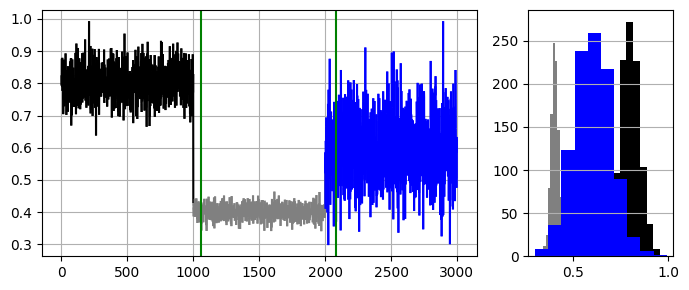

In [9]:
from river import drift

drift_detector = drift.ADWIN()
drifts = []

for i, val in enumerate(stream):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}')
        drifts.append(i)
plot_data(stream, dist_a, dist_b, dist_c, drifts=drifts, figname='ch03_drift_3_adwin.pdf')

## Synthetically Generated Drift Data: Friedman Drift

In [10]:
from river import drift
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from river.datasets import synth

dataset = synth.FriedmanDrift(
     drift_type='gra',
     position=(1_000, 2_000),
     seed=42)

stream = []
for x, y in dataset.take(3_000):
  stream.append(y)
stream = np.array(stream)
# print(stream)

In [11]:
drift_detector = drift.ADWIN()
drifts = []

for i, val in enumerate(stream):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}')
        drifts.append(i)

## Synthetically Generated Drift Data: SEA Drift

In [12]:
import copy
import pandas as pd
import warnings
import numbers
import json
import calendar
import math
import datetime as dt
import numpy as np
from numpy import power
from math import inf
import matplotlib.pyplot as plt
import river.stream as river_stream
from river.tree.splitter import EBSTSplitter, QOSplitter, TEBSTSplitter, GaussianSplitter, HistogramSplitter
from river.linear_model import LinearRegression, PARegressor, Perceptron
from river.tree import HoeffdingAdaptiveTreeRegressor
from river.tree import HoeffdingAdaptiveTreeClassifier
from river.preprocessing import StandardScaler
from river.compose import Pipeline
from river import compose
from river import datasets, time_series, utils, compose, linear_model, optim, preprocessing, evaluate, metrics, tree 
from river.datasets import synth
from river import feature_extraction
from river import stats, compose, preprocessing, tree
from river import metrics
from river.datasets import synth
from river import drift
from river import drift
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from river.datasets import synth

from sklearn.preprocessing import OneHotEncoder , MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline , Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
warnings.filterwarnings("ignore")

In [13]:
metric = accuracy_score
# metric = f1_score
horizon = 7*24
k = 1
n_total = int(k*100_000)
n_samples = n_total
position = int(k*25_000)
width = int(n_total/250)
n_train = 1_000
a = n_train + position - 50
b = a + 50
gen_1 = synth.ConceptDriftStream(
        stream=synth.SEA(seed=42, variant=0),
        drift_stream=synth.SEA(seed=42, variant=1),
                               seed=1, position=position, width=width)
gen_2 = synth.ConceptDriftStream(
        stream=synth.SEA(seed=42, variant=2),
        drift_stream=synth.SEA(seed=42, variant=3),
                               seed=1, position=position, width=width)
dataset = synth.ConceptDriftStream(stream=gen_1, drift_stream=gen_2, seed=1, position=2*position, width=width)
data_dict = {key: [] for key in list(dataset.take(1))[0][0].keys()}
data_dict["y"] = []
for x, y in dataset.take(n_total):
    for key, value in x.items():
        data_dict[key].append(value)
    data_dict["y"].append(y)
df = pd.DataFrame(data_dict)
# Add column names x1 until x10 to the first 10 columns of the dataframe and the column name y to the last column
df.columns = [f"x{i}" for i in range(1, 4)] + ["y"]
df = df.apply(lambda x: x.astype(int) if x.dtype == bool else x)
train = df[:n_train]
test = df[n_train:]
target_column = "y"

## Gradual Drift: df2

In [14]:
metric = accuracy_score
# metric = f1_score
horizon = 7*24
k = 1
n_total = int(k*100_000)
n_samples = n_total
position = int(k*25_000)
width = int(n_total/5)
n_train = 1_000
a = n_train + position - 50
b = a + 50
gen_1 = synth.ConceptDriftStream(
        stream=synth.SEA(seed=42, variant=0),
        drift_stream=synth.SEA(seed=42, variant=1),
                               seed=1, position=position, width=width)
gen_2 = synth.ConceptDriftStream(
        stream=synth.SEA(seed=42, variant=2),
        drift_stream=synth.SEA(seed=42, variant=3),
                               seed=1, position=position, width=width)
dataset = synth.ConceptDriftStream(stream=gen_1, drift_stream=gen_2, seed=1, position=2*position, width=width)
data_dict = {key: [] for key in list(dataset.take(1))[0][0].keys()}
data_dict["y"] = []
for x, y in dataset.take(n_total):
    for key, value in x.items():
        data_dict[key].append(value)
    data_dict["y"].append(y)
df2 = pd.DataFrame(data_dict)
# Add column names x1 until x10 to the first 10 columns of the dataframe and the column name y to the last column
df2.columns = [f"x{i}" for i in range(1, 4)] + ["y"]
df2 = df2.apply(lambda x: x.astype(int) if x.dtype == bool else x)
train = df2[:n_train]
test = df2[n_train:]
target_column = "y"

In [15]:
(position, width)

(25000, 20000)

In [16]:
def plot_sea_data(stream1, stream2=None, drifts=None, filename=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    # plot the y values of the samples in the df dataframe using a sliding window of 1000 samples
    stream1["y"].rolling(2500).mean().plot(color="black", label="SEA with abrupt drift")
    if stream2 is not None:
        stream2["y"].rolling(2500).mean().plot(color="grey", label="SEA with gradual drift")
    plt.axvline(position, color="red")
    plt.axvline(2*position, color="red")
    plt.axvline(3*position, color="red")
    # Use values from the drifts list to plot vertical lines
    if drifts:
        for i in drifts:
            plt.axvline(i, color="green")
    plt.legend()
    plt.show()
    if filename:
        fig.savefig(filename, format='pdf', dpi=300)

In [17]:
stream = df["y"].rolling(2500).mean()
stream = stream[2500:]
drift_detector = drift.ADWIN(delta=1e-9, clock=100, min_window_length=500)
drifts = []

for i, val in enumerate(stream):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}')
        drifts.append(i)
drifts

Change detected at index 8199
Change detected at index 24299
Change detected at index 30599
Change detected at index 42899
Change detected at index 48599
Change detected at index 52199
Change detected at index 60699
Change detected at index 73699
Change detected at index 76199
Change detected at index 85999
Change detected at index 96299


[8199, 24299, 30599, 42899, 48599, 52199, 60699, 73699, 76199, 85999, 96299]

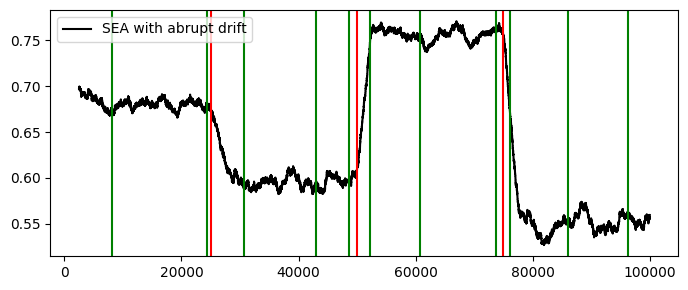

In [18]:
plot_sea_data(df, stream2=None, drifts=drifts, filename='ch03_drift_sea_adwin.pdf')